## Multi-Layer Perceptron Model for User Activity Prediction

A multilayer perceptron is a supervised learning algorithm based on artificial neural networks that consist of an input layer, one or more hidden layers, and an output layer. Each layer is composed of neurons that apply weighted linear combinations of the inputs followed by non linear activation functions, allowing the model to capture complex and non linear relationships in the data. During training, the network updates its weights using backpropagation to minimize a predefined loss function. MLP models are well suited for classification tasks where interactions between features are not easily captured by linear models. In this context, the MLP is used for binary classification to predict whether a user will be active or not based on early behavioural signals.

### 1. Imports and Setup

In [3]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [4]:
# import 
import logging
import time
from typing import Tuple, Dict, Any
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.models import Sequential

import keras_tuner as kt

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Set seeds
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-12-12 17:14:40.147938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.1
Keras version: 3.12.0
GPU Available: []


### 2. Load and Explore Data

In [5]:
df = pd.read_csv("../data/user_level_data.csv")

Dataset shape: (20011, 31)

First few rows:


,userId,y_active,province,age_gender_missing,followCnt_log,usr_like_rate,usr_share_rate,usr_comment_rate,usr_ever_inthomeviewed,usr_ever_shared,...,usr_only_click,usr_shared_x_liked,usr_shared_x_commented,usr_intohome_x_liked,avg_pop_index_pca,avg_content_pop_index,avg_pop_rank_exposure_row,avg_publishTime,max_creator_pop_index,entropy_pca
0,ICKCJCGCLCNCGCGCKC,0,hu nan,1,1.386294,0.0,0.0,0.0,0,0,...,1,0,0,0,2.256350,0.480283,1.180606,48.0,2.267197,-1.630660
1,ICKCMCHCJCKCJCGCJC,0,zhe jiang,1,1.791759,0.0,0.0,0.0,0,0,...,1,0,0,0,2.165025,1.093763,8.046980,99.5,5.094862,0.255795
2,ICMCICMCNCPCHCHCMC,0,jiang su,1,1.386294,0.0,0.0,0.0,0,0,...,1,0,0,0,3.397364,2.701603,1.068558,96.5,3.110704,0.255795
3,ICMCKCICKCPCLCKCOC,0,hu bei,1,1.609438,0.0,0.0,0.0,0,0,...,1,0,0,0,2.986048,0.246188,0.690819,26.0,1.754418,-1.630660
4,ICNCICLCICPCLCICOC,0,hu bei,1,1.386294,0.0,0.0,0.0,0,0,...,1,0,0,0,-2.020211,0.186660,0.155593,164.0,-0.820507,-1.630660



Target variable distribution:
y_active
0    14284
1     5727
Name: count, dtype: int64

Class balance:
y_active
0    0.713807
1    0.286193
Name: proportion, dtype: float64


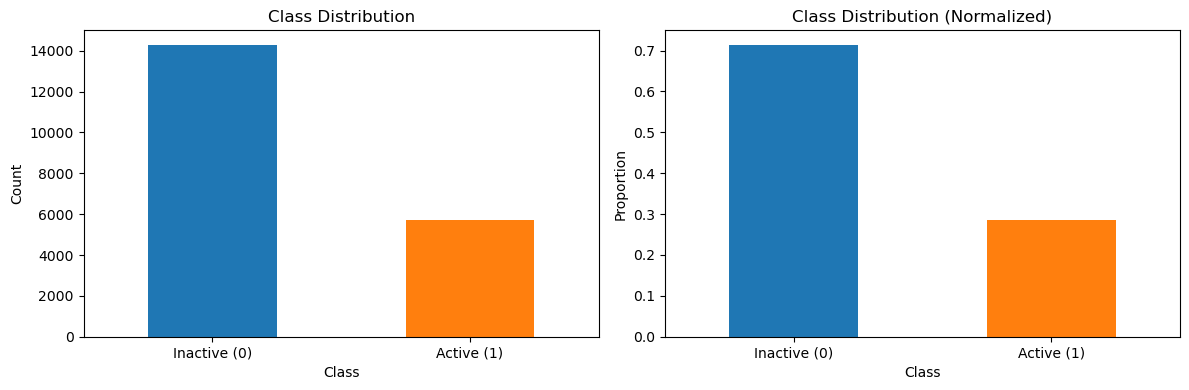

In [6]:

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Target distribution
print("\nTarget variable distribution:")
print(df["y_active"].value_counts())
print("\nClass balance:")
print(df["y_active"].value_counts(normalize=True))

# Visualize class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df["y_active"].value_counts().plot(kind="bar", ax=ax[0], color=["#1f77b4", "#ff7f0e"])
ax[0].set_title("Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")
ax[0].set_xticklabels(["Inactive (0)", "Active (1)"], rotation=0)

df["y_active"].value_counts(normalize=True).plot(kind="bar", ax=ax[1], color=["#1f77b4", "#ff7f0e"])
ax[1].set_title("Class Distribution (Normalized)")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Proportion")
ax[1].set_xticklabels(["Inactive (0)", "Active (1)"], rotation=0)
plt.tight_layout()
plt.show()

### 3. Prepare Features and Target

In [7]:
# Drop ID columns
id_cols = [col for col in df.columns if "id" in col.lower() or col == "userId"]
print(f"Dropping ID columns: {id_cols}")

X = df.drop(columns=id_cols + ["y_active"])
y = df["y_active"]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

Dropping ID columns: ['userId']

Feature matrix shape: (20011, 29)
Target vector shape: (20011,)

Feature columns: ['province', 'age_gender_missing', 'followCnt_log', 'usr_like_rate', 'usr_share_rate', 'usr_comment_rate', 'usr_ever_inthomeviewed', 'usr_ever_shared', 'usr_ever_commented', 'usr_shares_per_exp_follow', 'usr_action_rate', 'usr_sum_isLike_x_followlog', 'usr_sum_isComment_x_followlog', 'usr_followlog_x_actionrate', 'usr_engagement_span', 'usr_avg_dwell', 'usr_avg_position', 'usr_active_days', 'usr_weekend_share', 'usr_only_click', 'usr_shared_x_liked', 'usr_shared_x_commented', 'usr_intohome_x_liked', 'avg_pop_index_pca', 'avg_content_pop_index', 'avg_pop_rank_exposure_row', 'avg_publishTime', 'max_creator_pop_index', 'entropy_pca']


### 4. Train-Val-Test Split

In [ ]:
# Split data (80/20 train/test, then 80/20 train/val)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Training set size:   {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size:       {X_test.shape}")

Training set size:   (12806, 29)
Validation set size: (3202, 29)
Test set size:       (4003, 29)


### 5. Feature Preprocessing

In [9]:
# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")
if cat_cols:
    print(f"Categorical columns: {cat_cols}")

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_val_num = scaler.transform(X_val[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Encode categorical features
if cat_cols:
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train_cat = encoder.fit_transform(X_train[cat_cols])
    X_val_cat = encoder.transform(X_val[cat_cols])
    X_test_cat = encoder.transform(X_test[cat_cols])

    # Concatenate
    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_val_processed = np.hstack([X_val_num, X_val_cat])
    X_test_processed = np.hstack([X_test_num, X_test_cat])
else:
    X_train_processed = X_train_num
    X_val_processed = X_val_num
    X_test_processed = X_test_num

print(f"\nProcessed training data shape: {X_train_processed.shape}")
print(f"Processed validation data shape: {X_val_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Numeric features: 28
Categorical features: 1
Categorical columns: ['province']

Processed training data shape: (12806, 29)
Processed validation data shape: (3202, 29)
Processed test data shape: (4003, 29)


### 6. Compute Class Weights

In [10]:
# Compute class weights for imbalanced data
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print(f"Class weights: {class_weights}")

Class weights: {0: 0.7004704080516355, 1: 1.7470668485675307}


### 7. Define Model Building Function

In [11]:
def build_model(hp: kt.HyperParameters, input_dim: int) -> keras.Model:
    """
    Build MLP model with hyperparameter tuning.

    Args:
        hp: Keras Tuner HyperParameters object
        input_dim: Number of input features

    Returns:
        Compiled Keras model
    """
    model = Sequential(name="MLP_UserActivity")

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Number of hidden layers
    n_layers = hp.Int("n_layers", min_value=2, max_value=5, default=3)

    for i in range(n_layers):
        # Neurons per layer (decreasing pattern)
        if i == 0:
            units = hp.Int(f"units_layer_{i}", min_value=128, max_value=512, step=64, default=256)
        else:
            # Each layer has fewer neurons than the previous
            prev_units = hp.get(f"units_layer_{i-1}")
            max_units = max(64, prev_units // 2)
            units = hp.Int(f"units_layer_{i}", min_value=64, max_value=max_units, step=32, default=max_units)

        # Dense layer with L2 regularization
        l2_rate = hp.Float(f"l2_layer_{i}", min_value=1e-5, max_value=1e-2, sampling="log", default=1e-4)
        model.add(layers.Dense(
            units=units,
            kernel_regularizer=regularizers.l2(l2_rate),
            name=f"dense_{i}"
        ))

        # Batch normalization
        if hp.Boolean(f"batch_norm_{i}", default=True):
            model.add(layers.BatchNormalization(name=f"batch_norm_{i}"))

        # Activation
        activation = hp.Choice(f"activation_{i}", values=["relu", "elu", "selu"], default="relu")
        model.add(layers.Activation(activation, name=f"activation_{i}"))

        # Dropout
        dropout_rate = hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.5, step=0.1, default=0.3)
        model.add(layers.Dropout(dropout_rate, name=f"dropout_{i}"))

    # Output layer
    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    # Optimizer
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=1e-3)
    optimizer_name = hp.Choice("optimizer", values=["adam", "adamw", "rmsprop"], default="adam")

    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "adamw":
        optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compile
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall")
        ]
    )

    return model

### 8. Hyperparameter Tuning with Hyperband

In [ ]:
print("Starting Hyperparameter Tuning...\n")

# Use RandomSearch 
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, X_train_processed.shape[1]),
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=20,  
    executions_per_trial=1,
    directory="mlp_tuning",
    project_name="user_activity_prediction",
    overwrite=True,
    seed=RANDOM_STATE
)

# Callbacks for tuning
early_stop_tuning = callbacks.EarlyStopping(
    monitor="val_auc",
    patience=10,
    mode="max",
    restore_best_weights=True,
    verbose=0
)

# Search with memory optimization
tuner.search(
    X_train_processed, y_train.values,
    epochs=50,  
    batch_size=64,  
    validation_data=(X_val_processed, y_val.values),
    class_weight=class_weights,
    callbacks=[early_stop_tuning],
    verbose=1
)

print("\nHyperparameter tuning completed!")

Trial 20 Complete [00h 00m 35s]
val_auc: 0.9499989151954651

Best val_auc So Far: 0.9499989151954651
Total elapsed time: 00h 11m 08s

Hyperparameter tuning completed!


### 9. Best Hyperparameters

In [13]:
# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

print("="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# Display tuning results summary
print("\n" + "="*60)
print("TOP 5 MODELS")
print("="*60)
tuner.results_summary(num_trials=5)

BEST HYPERPARAMETERS
n_layers: 3
units_layer_0: 384
l2_layer_0: 0.00011916085656144355
batch_norm_0: False
activation_0: selu
dropout_0: 0.4
units_layer_1: 64
l2_layer_1: 1.1028688225777107e-05
batch_norm_1: False
activation_1: selu
dropout_1: 0.5
units_layer_2: 64
l2_layer_2: 0.0003439248278474982
batch_norm_2: False
activation_2: elu
dropout_2: 0.30000000000000004
learning_rate: 0.0002436074139531874
optimizer: rmsprop
units_layer_3: 64
l2_layer_3: 0.009233208458340405
batch_norm_3: False
activation_3: selu
dropout_3: 0.30000000000000004
units_layer_4: 64
l2_layer_4: 0.000368107351100381
batch_norm_4: True
activation_4: selu
dropout_4: 0.4

TOP 5 MODELS
Results summary
Results in mlp_tuning/user_activity_prediction
Showing 5 best trials
Objective(name="val_auc", direction="max")

Trial 19 summary
Hyperparameters:
n_layers: 3
units_layer_0: 384
l2_layer_0: 0.00011916085656144355
batch_norm_0: False
activation_0: selu
dropout_0: 0.4
units_layer_1: 64
l2_layer_1: 1.1028688225777107e-05


### 10. Build and Train Final Model

In [14]:
# Build model with best hyperparameters
final_model = build_model(best_hp, X_train_processed.shape[1])

print("="*60)
print("FINAL MODEL ARCHITECTURE")
print("="*60)
final_model.summary()

# Combine train and validation sets for final training
X_train_full = np.vstack([X_train_processed, X_val_processed])
y_train_full = np.concatenate([y_train.values, y_val.values])

print(f"\nFull training set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test_processed.shape}")

FINAL MODEL ARCHITECTURE


Model: "MLP_UserActivity"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 384)            │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_0 (Activation)       │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,385 (157.75 KB)

 Trainable params: 40,385 (157.75 KB)

 Non-trainable params: 0 (0.00 B)


Full training set shape: (16008, 29)
Test set shape: (4003, 29)


In [15]:
# Training callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_auc",
    patience=20,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.5,
    patience=10,
    mode="max",
    min_lr=1e-6,
    verbose=1
)

# Train
print("\nTraining final model...\n")
history = final_model.fit(
    X_train_full, y_train_full,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_processed, y_test.values),
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nTraining completed!")


Training final model...

Epoch 1/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7053 - auc: 0.7622 - loss: 0.7054 - precision: 0.4895 - recall: 0.6996 - val_accuracy: 0.8396 - val_auc: 0.9280 - val_loss: 0.4283 - val_precision: 0.6522 - val_recall: 0.9424 - learning_rate: 2.4361e-04
Epoch 2/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8077 - auc: 0.8885 - loss: 0.4716 - precision: 0.6221 - recall: 0.8354 - val_accuracy: 0.8474 - val_auc: 0.9377 - val_loss: 0.3933 - val_precision: 0.6605 - val_recall: 0.9607 - learning_rate: 2.4361e-04
Epoch 3/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8356 - auc: 0.9128 - loss: 0.3997 - precision: 0.6580 - recall: 0.8863 - val_accuracy: 0.8581 - val_auc: 0.9413 - val_loss: 0.3811 - val_precision: 0.6767 - val_recall: 0.9660 - learning_rate: 2.4361e-04
Epoch 4/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8484 - auc: 0.9211 - loss: 0.3653 - precision: 0.6744 - recall: 0.9092 - val_accuracy: 0.8634 

### 11. Model Evaluation

In [16]:
from sklearn.metrics import average_precision_score, precision_recall_curve, recall_score, precision_score

# Predictions
y_pred_proba = final_model.predict(X_test_processed, verbose=0).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred, average="weighted")
pr_auc = average_precision_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")

# Print results
print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(cm)
print(f"\nROC–AUC Score: {roc_auc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"PR–AUC Score: {pr_auc:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Precision (weighted): {precision:.4f}")


MODEL PERFORMANCE METRICS
Accuracy: 0.8783
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2857
           1       0.72      0.95      0.82      1146

    accuracy                           0.88      4003
   macro avg       0.85      0.90      0.86      4003
weighted avg       0.90      0.88      0.88      4003

Confusion Matrix:
[[2427  430]
 [  57 1089]]

ROC–AUC Score: 0.9486
F1 Score (weighted): 0.8826
PR–AUC Score: 0.8539
Recall (weighted): 0.8783
Precision (weighted): 0.9026


### 12. Comprehensive Visualizations

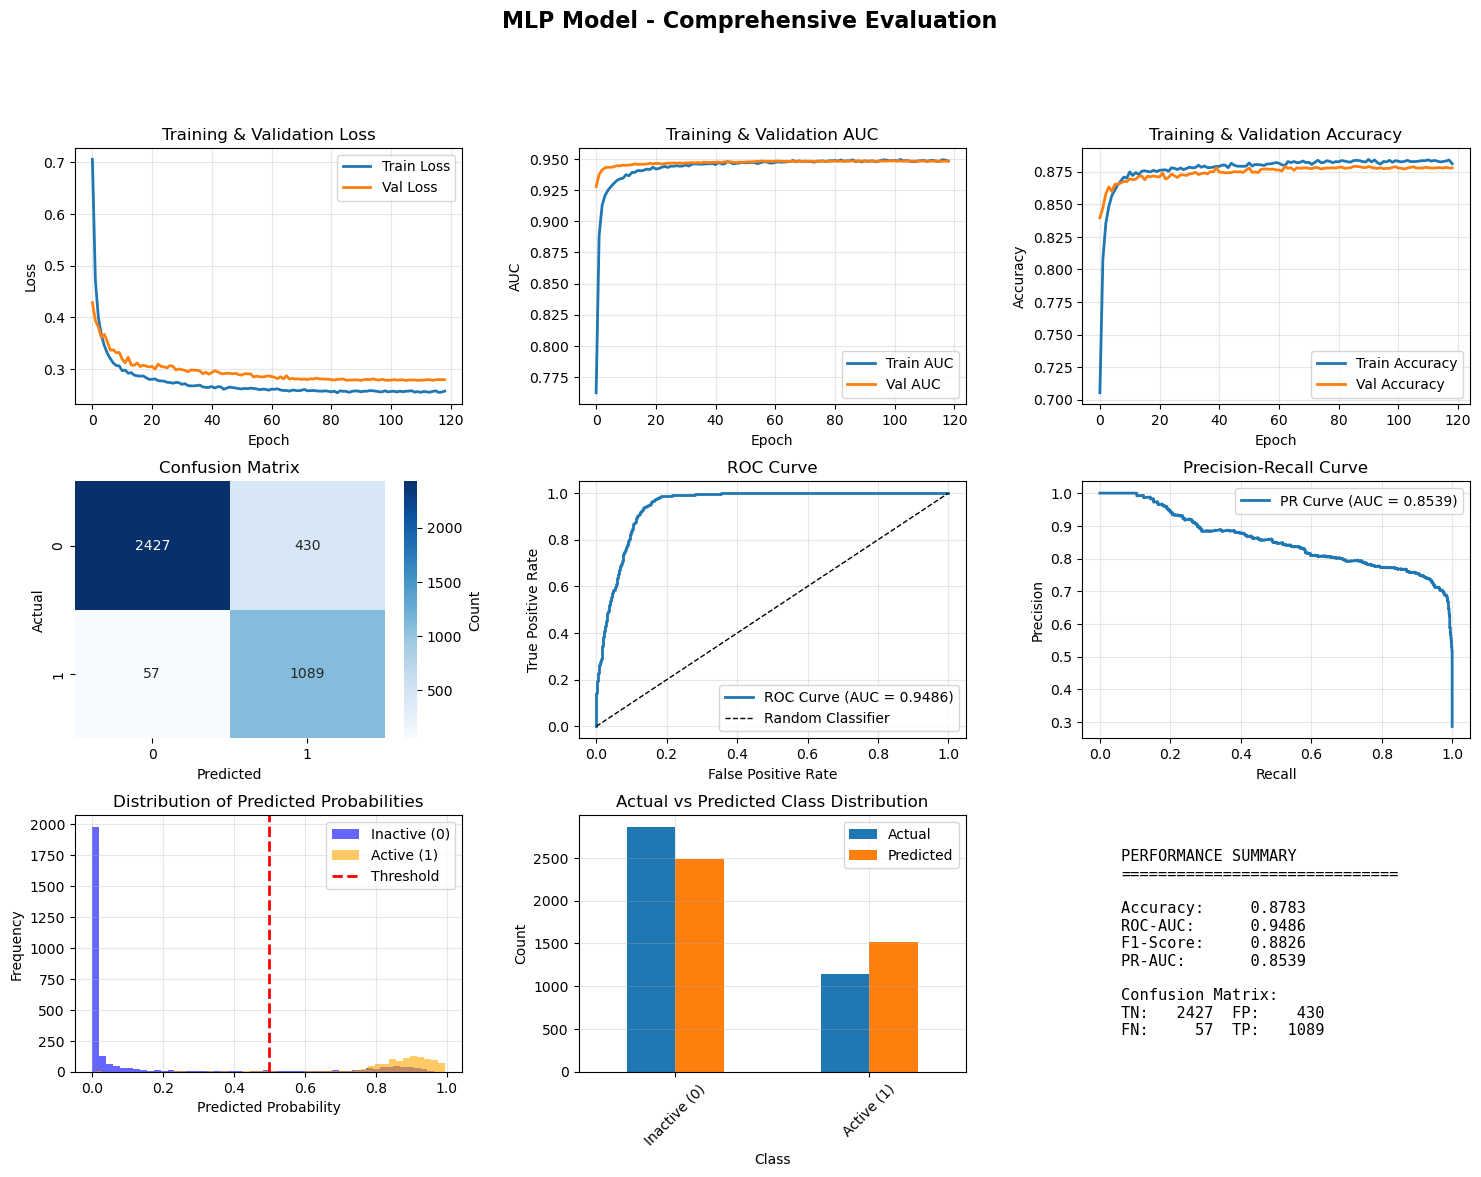

In [18]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Training History - Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history.history["loss"], label="Train Loss", linewidth=2)
ax1.plot(history.history["val_loss"], label="Val Loss", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Training History - AUC
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history.history["auc"], label="Train AUC", linewidth=2)
ax2.plot(history.history["val_auc"], label="Val AUC", linewidth=2)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("AUC")
ax2.set_title("Training & Validation AUC")
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Training History - Accuracy
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
ax3.plot(history.history["val_accuracy"], label="Val Accuracy", linewidth=2)
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Accuracy")
ax3.set_title("Training & Validation Accuracy")
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax4, cbar_kws={"label": "Count"})
ax4.set_title("Confusion Matrix")
ax4.set_ylabel("Actual")
ax4.set_xlabel("Predicted")

# 5. ROC Curve
ax5 = fig.add_subplot(gs[1, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax5.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
ax5.plot([0, 1], [0, 1], "k--", label="Random Classifier", linewidth=1)
ax5.set_xlabel("False Positive Rate")
ax5.set_ylabel("True Positive Rate")
ax5.set_title("ROC Curve")
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Precision-Recall Curve
ax6 = fig.add_subplot(gs[1, 2])
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_pred_proba)
ax6.plot(rec_curve, prec_curve, label=f"PR Curve (AUC = {pr_auc:.4f})", linewidth=2)
ax6.set_xlabel("Recall")
ax6.set_ylabel("Precision")
ax6.set_title("Precision-Recall Curve")
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Prediction Distribution
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, label="Inactive (0)", color="blue")
ax7.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, label="Active (1)", color="orange")
ax7.axvline(x=0.5, color="red", linestyle="--", linewidth=2, label="Threshold")
ax7.set_xlabel("Predicted Probability")
ax7.set_ylabel("Frequency")
ax7.set_title("Distribution of Predicted Probabilities")
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Class Distribution Comparison
ax8 = fig.add_subplot(gs[2, 1])
class_comparison = pd.DataFrame({
    "Actual": y_test.value_counts().sort_index(),
    "Predicted": pd.Series(y_pred).value_counts().sort_index()
})
class_comparison.plot(kind="bar", ax=ax8, color=["#1f77b4", "#ff7f0e"])
ax8.set_xlabel("Class")
ax8.set_ylabel("Count")
ax8.set_title("Actual vs Predicted Class Distribution")
ax8.set_xticklabels(["Inactive (0)", "Active (1)"], rotation=45)
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Metrics Summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis("off")
metrics_text = f"""
PERFORMANCE SUMMARY
{'='*30}

Accuracy:     {accuracy:.4f}
ROC-AUC:      {roc_auc:.4f}
F1-Score:     {f1:.4f}
PR-AUC:       {pr_auc:.4f}

Confusion Matrix:
TN: {cm[0, 0]:>6}  FP: {cm[0, 1]:>6}
FN: {cm[1, 0]:>6}  TP: {cm[1, 1]:>6}
"""
ax9.text(0.1, 0.5, metrics_text, fontsize=11, family="monospace", verticalalignment="center")

plt.suptitle("MLP Model - Comprehensive Evaluation", fontsize=16, fontweight="bold", y=0.995)
plt.savefig("mlp_evaluation_results.png", dpi=300, bbox_inches="tight")
plt.show()

### 13. Save Model

In [19]:
# Save model
final_model.save("mlp_user_activity_model.keras")
print("Model saved as 'mlp_user_activity_model.keras'")

# Save preprocessing objects
import joblib
joblib.dump(scaler, "scaler.pkl")
if cat_cols:
    joblib.dump(encoder, "encoder.pkl")
print("Preprocessing objects saved")

Model saved as 'mlp_user_activity_model.keras'
Preprocessing objects saved


### 14. Model Summary

In [ ]:
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"\nTotal parameters: {final_model.count_params():,}")
print(f"Number of layers: {len(final_model.layers)}")
print(f"\nTest set performance:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - ROC-AUC: {roc_auc:.4f}")
print(f"  - PR-AUC: {pr_auc:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - Precision: {precision:.4f}")



FINAL MODEL SUMMARY

Total parameters: 40,385
Number of layers: 10

Test set performance:
  - Accuracy: 0.8783
  - ROC-AUC: 0.9486
  - F1-Score: 0.8826
Recall (weighted): 0.8783
Precision (weighted): 0.9026


### 15. Feature Importance Analysis

In [21]:
print("Computing Permutation Feature Importance...")
print("This may take a few minutes as we evaluate each feature's impact...\n")

# Manual implementation of permutation importance
# This is more reliable and doesn't require sklearn wrapper compatibility

# Get baseline score
y_pred_baseline = final_model.predict(X_test_processed, verbose=0).flatten()
baseline_score = roc_auc_score(y_test, y_pred_baseline)

print(f"Baseline ROC-AUC: {baseline_score:.4f}\n")

# Create feature names list
feature_names = list(num_cols) + list(cat_cols)

# Store importance scores for each feature
n_repeats = 10
importance_scores = []

for idx, feature_name in enumerate(feature_names):
    feature_scores = []

    for repeat in range(n_repeats):
        # Create a copy of test data
        X_permuted = X_test_processed.copy()

        # Shuffle this feature
        np.random.seed(RANDOM_STATE + repeat)
        X_permuted[:, idx] = np.random.permutation(X_permuted[:, idx])

        # Get predictions with shuffled feature
        y_pred_permuted = final_model.predict(X_permuted, verbose=0).flatten()
        permuted_score = roc_auc_score(y_test, y_pred_permuted)

        # Importance = drop in performance
        feature_scores.append(baseline_score - permuted_score)

    # Calculate mean and std across repeats
    importance_scores.append({
        'feature': feature_name,
        'importance_mean': np.mean(feature_scores),
        'importance_std': np.std(feature_scores)
    })

    # Progress indicator
    if (idx + 1) % 5 == 0:
        print(f"Processed {idx + 1}/{len(feature_names)} features...")

print(f"\nCompleted! Processed all {len(feature_names)} features.\n")

# Create DataFrame with results
importance_df = pd.DataFrame(importance_scores).sort_values('importance_mean', ascending=False)

print("="*60)
print("PERMUTATION FEATURE IMPORTANCE (Top 20)")
print("="*60)
print("\nBased on ROC-AUC score when shuffling each feature")
print("Higher values = more important for predictions\n")
print(importance_df.head(20).to_string(index=False))

print("\n" + "="*60)
print("FEATURE IMPORTANCE STATISTICS")
print("="*60)
print(f"Total features analyzed: {len(feature_names)}")
print(f"Features with positive importance: {(importance_df['importance_mean'] > 0).sum()}")
print(f"Features with negative/zero importance: {(importance_df['importance_mean'] <= 0).sum()}")
print(f"\nMost important feature: {importance_df.iloc[0]['feature']}")
print(f"  - Importance: {importance_df.iloc[0]['importance_mean']:.4f} ± {importance_df.iloc[0]['importance_std']:.4f}")

Computing Permutation Feature Importance...
This may take a few minutes as we evaluate each feature's impact...

Baseline ROC-AUC: 0.9486

Processed 5/29 features...
Processed 10/29 features...
Processed 15/29 features...
Processed 20/29 features...
Processed 25/29 features...

Completed! Processed all 29 features.

PERMUTATION FEATURE IMPORTANCE (Top 20)

Based on ROC-AUC score when shuffling each feature
Higher values = more important for predictions

                      feature  importance_mean  importance_std
                  entropy_pca         0.249699        0.007169
               usr_only_click         0.038451        0.002163
   usr_followlog_x_actionrate         0.016117        0.001437
                usr_avg_dwell         0.013987        0.001680
            avg_pop_index_pca         0.006003        0.001319
                followCnt_log         0.005017        0.000790
              usr_action_rate         0.004250        0.000561
          usr_engagement_span         

### 16. Saving metrics to JSON

In [23]:
# Saving metrics to JSON
import os
import json

rf_scores = {
    "accuracy":  float(accuracy),
    "roc_auc":   float(roc_auc),
    "pr_auc":    float(pr_auc),
    "precision": float(precision),
    "recall":    float(recall),
    "f1":        float(f1)
}
 
scores_path = "final_scores.json"
 
if os.path.exists(scores_path):
    with open(scores_path, "r") as f:
        all_scores = json.load(f)
else:
    all_scores = {}
 
all_scores["Deep Neural Network"] = rf_scores
 
with open(scores_path, "w") as f:
    json.dump(all_scores, f, indent=2)

### 17. Save to pickle File

In [24]:
# SAVE TEST PREDICTIONS FOR MODEL COMPARISON (Bootstrap Difference CIs)
import pickle
from pathlib import Path
 
# Create directory if it doesn't exist
predictions_dir = Path("model_predictions")
predictions_dir.mkdir(exist_ok=True)
 
# Save test predictions
# Note: 'y_pred_proba' contains the test set probabilities from final_model.predict(X_test_processed, verbose=0).flatten()
with open(predictions_dir / "mlp_test_proba.pkl", "wb") as f:
    pickle.dump({
        'y_test': y_test,
        'test_proba': y_pred_proba,
        'model_name': 'MLP'
    }, f)
 
print("\n" + "="*60)
print("✓ Test predictions saved for model comparison")
print(f"  Saved to: {predictions_dir / 'mlp_test_proba.pkl'}")
print("="*60)


✓ Test predictions saved for model comparison
  Saved to: model_predictions/mlp_test_proba.pkl
